In [13]:
import rocketcea

In [14]:
import numpy

In [15]:
import scipy

In [16]:
import matplotlib

In [17]:
import rocketcea
import os
import numpy as np
import scipy
from scipy.optimize import minimize
import tkinter as tk  
import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.matplotlib_fname())
from rocketcea.cea_obj import CEA_Obj
import pandas as pd
import math 
import CoolProp.CoolProp as CP
import sys
sys.path.append("/mnt/c/users/<username>/...") #add path to wherever you are storing the downloaded file w the collapse function
from Collapse_Thrust_Conv import *

class propellant:
    def __init__(self,name, density, viscosity,tank_length, tank_radius, temperature):
        self.density = density
        self.viscosity = viscosity
        self.temp = temperature
        self.rad = tank_radius
        self.length = tank_length
        self.name = name
        return None
    def __str__(self) -> str:
        return self.name
    
class pressurant(propellant):
    def __init__(self, name, state = 'gas'):
        super.__init__(name, state)

/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/matplotlibrc


Final Pressure LOX tank: 440.07 psi
Final Pressure eth tank: 449.85 psi


/tmp/ipykernel_2927/2117000364.py:71: RuntimeWarning: invalid value encountered in scalar power
  mdot_eth = ((1/R_eth)*rho_ETH*(P_ethtank - Pc_test[i]))**(1/2)


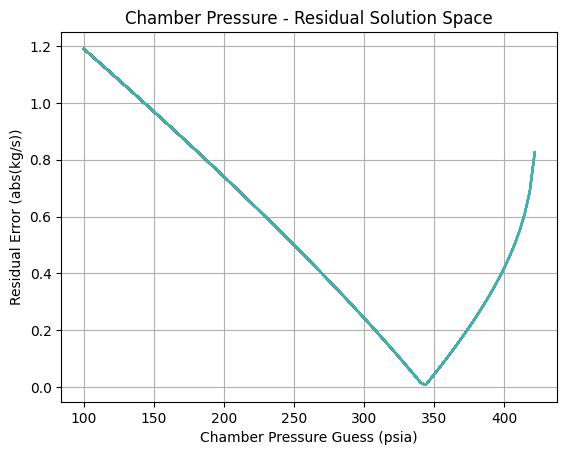

In [18]:
#Fluid Properties (SI units)
rho_LOX = 1140.0
rho_ETH = 798.0

#System Test Data Results
CdA_inj_LOX = 0.00001134 #faked for testing
CdA_inj_ETH = 0.00001078 #faked for testing

CdA_feed_LOX = 0.0000305333 #faked for testing
CdA_feed_ETH = 0.0000244267 #faked for testing

#Hydraulic Resistance Terms
R_ox_inj = 1/(2*(CdA_inj_LOX**2)) #dP=Rhyd*mdot^2/rho
R_eth_inj = 1/(2*(CdA_inj_ETH**2)) #dP=Rhyd*mdot^2/rho

R_ox_feed = 1/(2*(CdA_feed_LOX**2)) #dP=Rhyd*mdot^2/rho
R_eth_feed = 1/(2*(CdA_feed_ETH**2)) #dP=Rhyd*mdot^2/rho

R_ox = R_ox_inj + R_ox_feed #Equivalent Hydraulic System Resistance
R_eth = R_eth_inj + R_ox_feed #Equivalent Hydraulic System Resistance

#Tank Properties
gamma_tanks = 1.41 #1.41=GN2, 1.67=GHe
V_oxtank = 6.92655 #L
V_ethtank = 7.57 #L

V_oxinit = 3.25 #OPTMIMIZE THIS
V_ethinit = 3.0 #OPTIMIZE THIS

V_oxgas = V_oxtank-V_oxinit
V_ethgas = V_ethtank - V_ethinit

#Initial Tank Pressures
P_tank_ox_psi = 475.0 #psia
P_oxtank = P_tank_ox_psi*6895 #Pa

P_tank_eth_psi = 425.0 #psia
P_ethtank = P_tank_eth_psi*6895 #Pa

"""collapse stuff
- takes in ox/eth tank pressure (psi)
- outputs final pressures from waiting 15s after pressurizing (psi)
(to change how many seconds you're waiting edit the tSpan under #diffeq conditions)
"""
# Test
result1 = Collapse_OX(450)
print(f"Final Pressure LOX tank: {result1:.2f} psi")
result2 = Collapse_ETH(450)
print(f"Final Pressure eth tank: {result2:.2f} psi")

#define cstar efficiency: completeion of energy release. See RPE Pg64
Efficiency = 0.925
chamber = CEA_Obj(propName="", oxName="LOX", fuelName="C2H5OH") #initializs CEA object

#define Throat Diameter, Area
Dt = 26.04/1000 #m
At = (Dt**2)/4*math.pi

# Initialize Array
Residual = []

#create Chamber Pressure Guess Array
Pc_test_psi = np.linspace(100.0, 450.0, 100) #psia
Pc_test = Pc_test_psi*6895 #Pa

#solve residual for each pressure guess
for i in range(len(Pc_test)):
    
    #solve mass flow from fluid resistances
    mdot_ox = ((1/R_ox)*rho_LOX*(P_oxtank - Pc_test[i]))**(1/2)
    mdot_eth = ((1/R_eth)*rho_ETH*(P_ethtank - Pc_test[i]))**(1/2)
    mdot_fluid = mdot_ox + mdot_eth
    #get OF ratio
    OF_ratio_test = mdot_ox/mdot_eth

    #solve mass flow from CEA 
    Cstar_fps = chamber.get_Cstar(Pc=Pc_test_psi[i], MR=OF_ratio_test) #see RPE pg64
    Cstar = Cstar_fps*0.3048 #m
    mdot_CEA = Pc_test[i]*At/(Cstar*Efficiency) #kg/s

    #compare residual, append to array
    error = mdot_CEA-mdot_fluid
    Residual.append(abs(error))
    
    plt.plot(Pc_test_psi[:i+1], Residual[:i+1])
    plt.xlabel('Chamber Pressure Guess (psia)')
    plt.ylabel('Residual Error (abs(kg/s))')
    plt.title('Chamber Pressure - Residual Solution Space')
    plt.grid(True)

    
# Display the final plot after the loop
plt.show()

def Calculate_Residual(Pc, P_oxtank, P_ethtank):
    #solve mass flow from fluid resistances
    mdot_ox = ((1/R_ox)*rho_LOX*(P_oxtank - (Pc*6895)))**(1/2)
    mdot_eth = ((1/R_eth)*rho_ETH*(P_ethtank - (Pc*6895)))**(1/2)
    mdot_fluid = mdot_ox + mdot_eth
    #get OF ratio
    OF_ratio = mdot_ox/mdot_eth
    #solve mass flow from CEA 
    Cstar_fps = chamber.get_Cstar(Pc = Pc[0], MR = OF_ratio[0]) #see RPE pg64
    Cstar = float(Cstar_fps*0.3048) #m/s
    if Cstar == 0:
        print("CSTAR ZERO")
        print(f"PC = {Pc[0]}")
        mdot_CEA_res = Pc*6895*At/(abs(Cstar)*Efficiency)
    else:
        mdot_CEA_res = (Pc*6895)*At/(Cstar*Efficiency) #kg/s

    #compare residual, append to array
    error = mdot_CEA_res-mdot_fluid
    
    global OF_ratio_glob
    OF_ratio_glob = float(OF_ratio[0])

    global mdot_total_glob
    mdot_total_glob = float(mdot_fluid[0])

    if OF_ratio > 1.8: #tank pressure drop eqs breaking
        error = 500

    return abs(error)

def GradientDescent(guess, P_oxtank, P_ethtank):
    # Use scipy optimize minimize with residual function to find Chamber Pressure
    result = minimize(
        Calculate_Residual,
        guess,
        args = (P_oxtank, P_ethtank),
        bounds = [(100, min([P_oxtank/6895, P_ethtank/6895]))],
    )
    P_chamber = result.x[0]
    # t = type(P_chamber)
    #print(f"Pchamb TYPE {t}")
    OF = OF_ratio_glob
    isp = chamber.estimate_Ambient_Isp(Pc=P_chamber,MR=OF,eps=4.35)[0]
    thrust = 9.8*isp*(mdot_total_glob)/1000 #kN
    print(f"Thrust {thrust}")
    massflow_total = mdot_total_glob
    print(f"massflow {massflow_total}")
    #print(f"PC {P_chamber/6895} and MR {OF_ratio} at {i*dt}")

    return P_chamber, thrust, OF, massflow_total


TIMESTEP 0.10050251256281408
Thrust 1.9787652247250116
massflow 0.7903713507625868
Oxtank = 467.3243503261677[psi] ... Ethtank = 420.001692256789[psi] at 0.0
Thrust 1.9523627250035096
massflow 0.7813058140641851
Oxtank = 459.9645798039857[psi] ... Ethtank = 413.98681064002295[psi] at 0.10050251256281408
Thrust 1.9252484042064868
massflow 0.7717953527088681
Oxtank = 452.88957824945993[psi] ... Ethtank = 408.1905511424286[psi] at 0.20100502512562815
Thrust 1.8990367129023915
massflow 0.7626006277550317
Oxtank = 446.0822295855803[psi] ... Ethtank = 402.60037684600826[psi] at 0.30150753768844224
Thrust 1.8736788541716611
massflow 0.7537046189032806
Oxtank = 439.5267952072465[psi] ... Ethtank = 397.2047223427037[psi] at 0.4020100502512563
Thrust 1.8491299381323363
massflow 0.7450915925355786
Oxtank = 433.2087761080565[psi] ... Ethtank = 391.9928994169013[psi] at 0.5025125628140704
Thrust 1.8253480811546725
massflow 0.7367469302428156
Oxtank = 427.1147917250549[psi] ... Ethtank = 386.9550140

Thrust 1.7371535252087709
massflow 0.7057940832369238
Oxtank = 404.7450577870045[psi] ... Ethtank = 368.36885341167573[psi] at 1.0050251256281408
Thrust 1.7166749204015679
massflow 0.6986052860893235
Oxtank = 399.60281637956683[psi] ... Ethtank = 364.0753066122488[psi] at 1.105527638190955
Thrust 1.6967664831439029
massflow 0.6916160217444122
Oxtank = 394.6225786294375[psi] ... Ethtank = 359.9093965862145[psi] at 1.206030150753769
Thrust 1.6774024901226048
massflow 0.684817292615304
Oxtank = 389.7963739954984[psi] ... Ethtank = 355.8651148418568[psi] at 1.306532663316583
Thrust 1.6585586538198018
massflow 0.6782006473033588
Oxtank = 385.1167593089366[psi] ... Ethtank = 351.9368364998048[psi] at 1.407035175879397
Thrust 1.6402124685517052
massflow 0.6717581729513111
Oxtank = 380.5767751382402[psi] ... Ethtank = 348.11928941769116[psi] at 1.5075376884422111
Thrust 1.622342540137157
massflow 0.6654824105485839
Oxtank = 376.1699066863894[psi] ... Ethtank = 344.4075265895905[psi] at 1.60804

/tmp/ipykernel_2927/2117000364.py:98: RuntimeWarning: invalid value encountered in sqrt
  mdot_eth = ((1/R_eth)*rho_ETH*(P_ethtank - (Pc*6895)))**(1/2)
/tmp/ipykernel_2927/2117000364.py:108: RuntimeWarning: divide by zero encountered in divide
  mdot_CEA_res = Pc*6895*At/(abs(Cstar)*Efficiency)
/tmp/ipykernel_2927/2117000364.py:101: RuntimeWarning: divide by zero encountered in divide
  OF_ratio = mdot_ox/mdot_eth


Thrust 1.2192582826936251
massflow 0.5237596153870434
Oxtank = 280.8089258413464[psi] ... Ethtank = 262.5161604705761[psi] at 4.824120603015076
CSTAR ZERO
PC = 262.5161604605761
Thrust 1.2102422878255787
massflow 0.520585465248623
Oxtank = 278.76526528067905[psi] ... Ethtank = 260.7263512044933[psi] at 4.92462311557789
Thrust 1.201375289980843
massflow 0.5174635929716046
Oxtank = 276.75923966933885[psi] ... Ethtank = 258.96799995747807[psi] at 5.025125628140704
Thrust 1.1926534324338607
massflow 0.5143926013348071
Oxtank = 274.7897545957462[psi] ... Ethtank = 257.24022498955014[psi] at 5.125628140703518
Thrust 1.1840727377830587
massflow 0.5113711359640924
Oxtank = 272.85575882881614[psi] ... Ethtank = 255.5421783141662[psi] at 5.226130653266332
Thrust 1.1756295708011721
massflow 0.5083978987304318
Oxtank = 270.95624215687053[psi] ... Ethtank = 253.8730440407556[psi] at 5.326633165829146
Thrust 1.167320297059185
massflow 0.5054716342600545
Oxtank = 269.0902333896198[psi] ... Ethtank = 

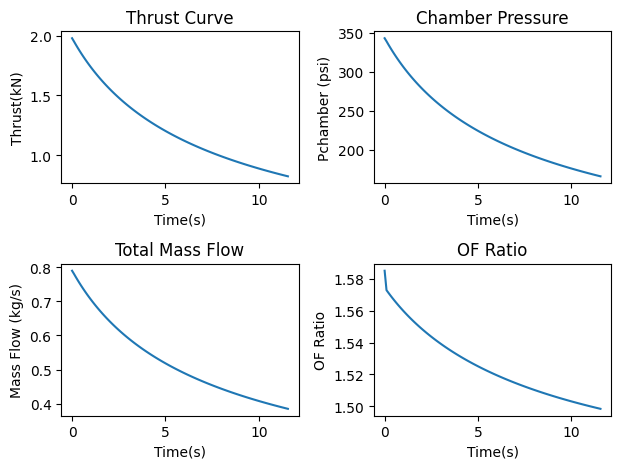

In [19]:

#reference thrust curve
iterations = 200
time = np.linspace(0, 20, iterations) #200 pts from 0 to 15 seconds
dt = float(time[1]-time[0])
print(f"TIMESTEP {dt}")
OF_array = []
Thrust_array = []
P_chamber_array = []
mdtot_array = []
fin = 0
for i in range(len(time)): #perform this for every timestep in the profile

    if i == 0:
        Pc_guess = 350
    else:
        Pc_guess = P_chamber_last-5
    
    P_chamber, Thrust, OF, md_tot = GradientDescent(Pc_guess, P_oxtank, P_ethtank)
    md_ox = md_tot/(
        1+1/OF) 
    md_eth = md_tot-md_ox
    
    #print(f"Timestep {dt}")
    masslost_ox = md_ox*dt
    masslost_eth = md_eth*dt
    #print(f"masslostox {masslost_ox}")
    
    #print(f"Voxgas(L) {V_oxgas}")
    V_oxgas_next = V_oxgas + (masslost_ox/(rho_LOX*0.001))
    V_ethgas_next = V_ethgas + (masslost_eth/(rho_ETH*0.001))
    #print(f"Voxgasnext(L) {V_oxgas_next}")

    P_oxtank = P_oxtank*((V_oxgas/V_oxgas_next)**gamma_tanks)
    P_ethtank = P_ethtank*((V_ethgas/V_ethgas_next)**gamma_tanks)
    print(f"Oxtank = {P_oxtank/6895}[psi] ... Ethtank = {P_ethtank/6895}[psi] at {i*dt}")

    V_oxgas = V_oxgas_next
    V_ethgas = V_oxgas_next

    mdtot_array.append(md_tot)
    OF_array.append(OF)
    Thrust_array.append(Thrust)
    P_chamber_array.append(P_chamber)
    assert len(Thrust_array) == len(P_chamber_array)
    P_chamber_last = P_chamber

    if P_chamber>(0.90*P_oxtank/6895) or P_chamber>(0.90*P_oxtank/6895):
        OxDrop = (P_oxtank/6895)/P_chamber
        ETHDrop = (P_ethtank/6895)/P_chamber
        print(f"Flow Stability Violated with {OxDrop}% LOXratio and {ETHDrop}% ETHratio")
        break

    if V_oxgas>=(V_oxtank-V_oxtank/250) or V_ethgas>=(V_ethtank-V_ethtank/250):
        oxrem = V_oxtank-V_oxgas
        ethrem = V_ethtank-V_ethgas
        print(f"Burn finished with {oxrem}L LOX and {ethrem}L ETH at Time {i*dt}s")
        break
        
# Create the subplots and plot the data
fig, axs = plt.subplots(2, 2)
sc = axs[0, 0].plot(time[0:len(Thrust_array)], Thrust_array)
axs[0, 0].set_title("Thrust Curve")
axs[0, 0].set_xlabel("Time(s)")
axs[0, 0].set_ylabel("Thrust(kN)")

axs[0, 1].plot(time[0:len(Thrust_array)], P_chamber_array)
axs[0, 1].set_title("Chamber Pressure")
axs[0, 1].set_xlabel("Time(s)")
axs[0, 1].set_ylabel("Pchamber (psi)")

axs[1, 0].plot(time[0:len(Thrust_array)], mdtot_array)
axs[1, 0].set_title("Total Mass Flow")
axs[1, 0].set_xlabel("Time(s)")
axs[1, 0].set_ylabel("Mass Flow (kg/s)")

axs[1, 1].plot(time[0:len(Thrust_array)], OF_array)
axs[1, 1].set_title("OF Ratio")
axs[1, 1].set_xlabel("Time(s)")
axs[1, 1].set_ylabel("OF Ratio")

# Adjust layout
plt.tight_layout()

# WRITE TO .ENG FILE
# file_path = "data/motors/LE2.eng"  # Specify the desired file path

# if not os.path.exists(file_path):
#     f = open(file_path, "x")
#     f.close()

# # Open the file for writing
# with open(file_path, "w") as f:
#     f.write("; ALULA - LE2 \n")
#     f.write("; 8/1/2023 ver. \n")
#     f.write("; created by UCB STAR \n")
#     f.write("LE2 98 732 0 6.325 8.98822 ALULA\n")  

#     for i in range(len(Thrust_array)):
#         f.write(f"{str(time[i])} {str(Thrust_array[i] * 1000)}\n")  # Thrust_array values in N

# # Display the plots
# %matplotlib inline
# plt.show()